In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 128

In [3]:
file_name = 'wheat_30_var_2_species.csv'

def dir(file_name):
    return '../data/'+file_name

In [4]:
def seperate_X_Y(dataframe):
    return (dataframe.drop('classes', axis =1), dataframe.loc[:,'classes'])

In [5]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3

FILT = 2
FILTER = filter_method(FILT).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = 1

#will be used for test dataset in msc
reference= None

In [6]:
from sklearn.model_selection import train_test_split
def create_test_train(X, y, test_size = 0.2, shuffle = True):
    return train_test_split(X,y, test_size = test_size, shuffle=shuffle)

In [7]:
#Standard Normal Variate
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [8]:
# Multiplicative scatter correction
def msc(input_data, reference=None):
#     print(reference)
    ''' Perform Multiplicative scatter correction'''

    # Baseline correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        matm = np.mean(input_data, axis=0)
    else:
        matm = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(matm, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 

    return (output_data, matm)

In [9]:
from scipy.signal import savgol_filter, general_gaussian
def savgol(input_data):
    w = WINDOW
    p = ORDER
    d = DERIVATIVE
    
    output_data = savgol_filter(np.array(input_data), w, polyorder = p, deriv=d)
    
    return output_data

In [10]:
def preprocess_data(X,y, type="train"):
    if FILTER == "snv":
        return {"X": snv(np.array(X)), "y": y}
    elif FILTER == "msc":
        msc_output = msc(np.array(X), reference = reference if type=="test" else None)
        X = msc_output[0]
        ref = msc_output[1]
        return {
            "X": X,
            "y": y,
            "ref": ref
        }
    elif FILTER == "savgol":
        return {
            "X": savgol(X),
            "y": y
        }
    else:
        return {
            "X":X,
            "y":y
        }

In [11]:
dataset = pd.read_csv(dir(file_name))
X,y = seperate_X_Y(dataset)

In [12]:
y_set = set(y)

In [13]:
NUM_OF_CLASSES = len(y_set)

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = create_test_train(X,y)

In [15]:
preprocessed_results = preprocess_data(X_train_raw,y_train_raw)
X_train, y_train = preprocessed_results["X"], preprocessed_results["y"]

if FILTER == "msc":
    reference = preprocessed_results["ref"]
    
preprocessed_results_test = preprocess_data(X_test_raw, y_test_raw, type="test")
X_test, y_test = preprocessed_results_test["X"], preprocessed_results_test["y"]

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)

(48384, 147, 1)
(12096, 147, 1)


In [17]:
import keras
from keras import Sequential
from keras.layers import Input, Conv1D, Flatten, Dense, MaxPooling1D

In [18]:
def createModel(input_shape,num_classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Conv1D(filters=64, kernel_size=5))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(800, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])
    
    return model

In [19]:
model = createModel(X_train.shape[1:],NUM_OF_CLASSES)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 28, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1000)              2

In [21]:
train_eva = []
test_eva = []

In [22]:
history_dataframe = pd.DataFrame() 

In [23]:
from IPython.display import clear_output

for x in range(400):
    print("\nEpoch: ",x+1)
    history = model.fit(X_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, shuffle=True)
    if history_dataframe.size == 0:
        history_dataframe = pd.DataFrame.from_dict(history.history)
    else:
        history_dataframe = pd.concat([history_dataframe,pd.DataFrame.from_dict(history.history)],axis=0,ignore_index=True)
    
    print("for training")
    train_eva.append(model.evaluate(X_train,y_train))
    print("for testing")
    test_eva.append(model.evaluate(X_test, y_test))
    
#     clear_output(wait=True)


Epoch:  1
378/378 - 16s - loss: 0.6238 - accuracy: 0.6460 - 16s/epoch - 43ms/step
for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.5882 - accuracy: 0.6911
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.5872 - accuracy: 0.6953

Epoch:  2
378/378 - 14s - loss: 0.5537 - accuracy: 0.7193 - 14s/epoch - 38ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.4111 - accuracy: 0.8385
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.4095 - accuracy: 0.8425

Epoch:  3
378/378 - 12s - loss: 0.3337 - accuracy: 0.8521 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.2809 - accuracy: 0.8780
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.2804 - accuracy: 0.8777

Epoch:  4
378/378 - 12s - loss: 0.2887 - accuracy: 0.8737 - 12s/epoch - 32ms/step
for training
1512/1512 [==========================

for training
1512/1512 [==============================] - 13s 9ms/step - loss: 0.1292 - accuracy: 0.9473
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.1277 - accuracy: 0.9472

Epoch:  30
378/378 - 13s - loss: 0.1311 - accuracy: 0.9460 - 13s/epoch - 35ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.1287 - accuracy: 0.9472
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.1281 - accuracy: 0.9513

Epoch:  31
378/378 - 12s - loss: 0.1354 - accuracy: 0.9443 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.1211 - accuracy: 0.9500
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.1234 - accuracy: 0.9502

Epoch:  32
378/378 - 12s - loss: 0.1350 - accuracy: 0.9449 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.1423 - accuracy: 0.9412
for testing
378/378 [====

1512/1512 [==============================] - 10s 7ms/step - loss: 0.1138 - accuracy: 0.9541
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.1179 - accuracy: 0.9542

Epoch:  58
378/378 - 12s - loss: 0.0951 - accuracy: 0.9623 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0771 - accuracy: 0.9703
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0810 - accuracy: 0.9702

Epoch:  59
378/378 - 12s - loss: 0.0964 - accuracy: 0.9610 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0804 - accuracy: 0.9685
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0846 - accuracy: 0.9683

Epoch:  60
378/378 - 12s - loss: 0.0935 - accuracy: 0.9627 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0880 - accuracy: 0.9642
for testing
378/378 [=================

1512/1512 [==============================] - 10s 7ms/step - loss: 0.0991 - accuracy: 0.9609
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.1086 - accuracy: 0.9575

Epoch:  86
378/378 - 12s - loss: 0.0726 - accuracy: 0.9718 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0817 - accuracy: 0.9680
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0929 - accuracy: 0.9638

Epoch:  87
378/378 - 12s - loss: 0.0656 - accuracy: 0.9754 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0647 - accuracy: 0.9754
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0715 - accuracy: 0.9734

Epoch:  88
378/378 - 12s - loss: 0.0728 - accuracy: 0.9713 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0727 - accuracy: 0.9714
for testing
378/378 [=================

1512/1512 [==============================] - 11s 7ms/step - loss: 0.0426 - accuracy: 0.9847
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0509 - accuracy: 0.9812

Epoch:  114
378/378 - 12s - loss: 0.0513 - accuracy: 0.9805 - 12s/epoch - 32ms/step
for training
1512/1512 [==============================] - 11s 7ms/step - loss: 0.0674 - accuracy: 0.9745
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0796 - accuracy: 0.9701

Epoch:  115
378/378 - 12s - loss: 0.0546 - accuracy: 0.9799 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0424 - accuracy: 0.9850
for testing
378/378 [==============================] - 2s 4ms/step - loss: 0.0492 - accuracy: 0.9817

Epoch:  116
378/378 - 12s - loss: 0.0525 - accuracy: 0.9804 - 12s/epoch - 32ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0400 - accuracy: 0.9858
for testing
378/378 [================

1512/1512 [==============================] - 7s 5ms/step - loss: 0.0355 - accuracy: 0.9869
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0443 - accuracy: 0.9837

Epoch:  142
378/378 - 10s - loss: 0.0434 - accuracy: 0.9839 - 10s/epoch - 27ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0350 - accuracy: 0.9873
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0451 - accuracy: 0.9835

Epoch:  143
378/378 - 11s - loss: 0.0428 - accuracy: 0.9843 - 11s/epoch - 29ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0323 - accuracy: 0.9887
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0395 - accuracy: 0.9857

Epoch:  144
378/378 - 11s - loss: 0.0404 - accuracy: 0.9853 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0503 - accuracy: 0.9804
for testing
378/378 [==================

1512/1512 [==============================] - 7s 5ms/step - loss: 0.0620 - accuracy: 0.9758
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0804 - accuracy: 0.9720

Epoch:  170
378/378 - 10s - loss: 0.0346 - accuracy: 0.9869 - 10s/epoch - 28ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0292 - accuracy: 0.9888
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0454 - accuracy: 0.9859

Epoch:  171
378/378 - 12s - loss: 0.0354 - accuracy: 0.9869 - 12s/epoch - 31ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0299 - accuracy: 0.9883
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0463 - accuracy: 0.9840

Epoch:  172
378/378 - 11s - loss: 0.0356 - accuracy: 0.9863 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0325 - accuracy: 0.9876
for testing
378/378 [==================

1512/1512 [==============================] - 16s 11ms/step - loss: 0.0354 - accuracy: 0.9867
for testing
378/378 [==============================] - 3s 7ms/step - loss: 0.0499 - accuracy: 0.9807

Epoch:  198
378/378 - 16s - loss: 0.0295 - accuracy: 0.9889 - 16s/epoch - 42ms/step
for training
1512/1512 [==============================] - 10s 7ms/step - loss: 0.0184 - accuracy: 0.9936
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0320 - accuracy: 0.9886

Epoch:  199
378/378 - 15s - loss: 0.0281 - accuracy: 0.9896 - 15s/epoch - 40ms/step
for training
1512/1512 [==============================] - 9s 6ms/step - loss: 0.0224 - accuracy: 0.9917
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0361 - accuracy: 0.9878

Epoch:  200
378/378 - 14s - loss: 0.0294 - accuracy: 0.9890 - 14s/epoch - 37ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0343 - accuracy: 0.9861
for testing
378/378 [===============

1512/1512 [==============================] - 9s 6ms/step - loss: 0.0174 - accuracy: 0.9937
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0319 - accuracy: 0.9883

Epoch:  226
378/378 - 11s - loss: 0.0241 - accuracy: 0.9907 - 11s/epoch - 28ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0299 - accuracy: 0.9878
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0477 - accuracy: 0.9830

Epoch:  227
378/378 - 11s - loss: 0.0229 - accuracy: 0.9914 - 11s/epoch - 28ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0292 - accuracy: 0.9887
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0444 - accuracy: 0.9847

Epoch:  228
378/378 - 11s - loss: 0.0230 - accuracy: 0.9912 - 11s/epoch - 28ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0139 - accuracy: 0.9954
for testing
378/378 [==================

1512/1512 [==============================] - 7s 5ms/step - loss: 0.0370 - accuracy: 0.9857
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0582 - accuracy: 0.9812

Epoch:  254
378/378 - 13s - loss: 0.0218 - accuracy: 0.9918 - 13s/epoch - 35ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0169 - accuracy: 0.9939
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0300 - accuracy: 0.9888

Epoch:  255
378/378 - 11s - loss: 0.0202 - accuracy: 0.9921 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0114 - accuracy: 0.9960
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0251 - accuracy: 0.9912

Epoch:  256
378/378 - 11s - loss: 0.0154 - accuracy: 0.9946 - 11s/epoch - 28ms/step
for training
1512/1512 [==============================] - 7s 5ms/step - loss: 0.0157 - accuracy: 0.9942
for testing
378/378 [==================

1512/1512 [==============================] - 8s 5ms/step - loss: 0.0140 - accuracy: 0.9944
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0324 - accuracy: 0.9883

Epoch:  282
378/378 - 12s - loss: 0.0150 - accuracy: 0.9944 - 12s/epoch - 32ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0111 - accuracy: 0.9959
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0304 - accuracy: 0.9903

Epoch:  283
378/378 - 11s - loss: 0.0185 - accuracy: 0.9928 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0254 - accuracy: 0.9902
for testing
378/378 [==============================] - 2s 5ms/step - loss: 0.0417 - accuracy: 0.9864

Epoch:  284
378/378 - 11s - loss: 0.0147 - accuracy: 0.9946 - 11s/epoch - 30ms/step
for training
1512/1512 [==============================] - 8s 5ms/step - loss: 0.0309 - accuracy: 0.9878
for testing
378/378 [==================

1512/1512 [==============================] - 16s 10ms/step - loss: 0.0386 - accuracy: 0.9856
for testing
378/378 [==============================] - 4s 11ms/step - loss: 0.0616 - accuracy: 0.9797

Epoch:  310
378/378 - 16s - loss: 0.0138 - accuracy: 0.9948 - 16s/epoch - 42ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0144 - accuracy: 0.9945
for testing
378/378 [==============================] - 4s 11ms/step - loss: 0.0351 - accuracy: 0.9888

Epoch:  311
378/378 - 16s - loss: 0.0170 - accuracy: 0.9939 - 16s/epoch - 42ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0143 - accuracy: 0.9946
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.0329 - accuracy: 0.9894

Epoch:  312
378/378 - 16s - loss: 0.0162 - accuracy: 0.9938 - 16s/epoch - 43ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0158 - accuracy: 0.9941
for testing
378/378 [=======

1512/1512 [==============================] - 15s 10ms/step - loss: 0.0113 - accuracy: 0.9959
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.0319 - accuracy: 0.9906

Epoch:  338
378/378 - 16s - loss: 0.0134 - accuracy: 0.9948 - 16s/epoch - 42ms/step
for training
1512/1512 [==============================] - 16s 11ms/step - loss: 0.0183 - accuracy: 0.9927
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.0400 - accuracy: 0.9866

Epoch:  339
378/378 - 16s - loss: 0.0102 - accuracy: 0.9962 - 16s/epoch - 43ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0059 - accuracy: 0.9980
for testing
378/378 [==============================] - 4s 9ms/step - loss: 0.0291 - accuracy: 0.9916

Epoch:  340
378/378 - 16s - loss: 0.0135 - accuracy: 0.9951 - 16s/epoch - 42ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0086 - accuracy: 0.9970
for testing
378/378 [==========

1512/1512 [==============================] - 16s 10ms/step - loss: 0.0157 - accuracy: 0.9937
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.0347 - accuracy: 0.9874

Epoch:  366
378/378 - 16s - loss: 0.0104 - accuracy: 0.9960 - 16s/epoch - 44ms/step
for training
1512/1512 [==============================] - 18s 12ms/step - loss: 0.0171 - accuracy: 0.9932
for testing
378/378 [==============================] - 5s 12ms/step - loss: 0.0412 - accuracy: 0.9872

Epoch:  367
378/378 - 20s - loss: 0.0147 - accuracy: 0.9950 - 20s/epoch - 53ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0069 - accuracy: 0.9977
for testing
378/378 [==============================] - 4s 10ms/step - loss: 0.0300 - accuracy: 0.9907

Epoch:  368
378/378 - 16s - loss: 0.0099 - accuracy: 0.9961 - 16s/epoch - 43ms/step
for training
1512/1512 [==============================] - 15s 10ms/step - loss: 0.0065 - accuracy: 0.9978
for testing
378/378 [=======

1512/1512 [==============================] - 16s 11ms/step - loss: 0.0123 - accuracy: 0.9956
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0391 - accuracy: 0.9900

Epoch:  394
378/378 - 17s - loss: 0.0111 - accuracy: 0.9961 - 17s/epoch - 45ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0025 - accuracy: 0.9995
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0250 - accuracy: 0.9924

Epoch:  395
378/378 - 13s - loss: 0.0070 - accuracy: 0.9976 - 13s/epoch - 35ms/step
for training
1512/1512 [==============================] - 14s 9ms/step - loss: 0.0064 - accuracy: 0.9975
for testing
378/378 [==============================] - 3s 8ms/step - loss: 0.0346 - accuracy: 0.9896

Epoch:  396
378/378 - 14s - loss: 0.0118 - accuracy: 0.9957 - 14s/epoch - 37ms/step
for training
1512/1512 [==============================] - 12s 8ms/step - loss: 0.0202 - accuracy: 0.9927
for testing
378/378 [=============

In [24]:
history_dataframe

,loss,accuracy
0,0.623773,0.645957
1,0.553715,0.719308
2,0.333724,0.852079
3,0.288693,0.873677
4,0.263767,0.884590
...,...,...
395,0.011801,0.995680
396,0.010046,0.996424
397,0.004988,0.998429
398,0.005319,0.998037


In [25]:
train_eva_df = pd.DataFrame(train_eva,columns=['loss','accuracy'])
test_eva_df = pd.DataFrame(test_eva,columns=['loss','accuracy'])

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

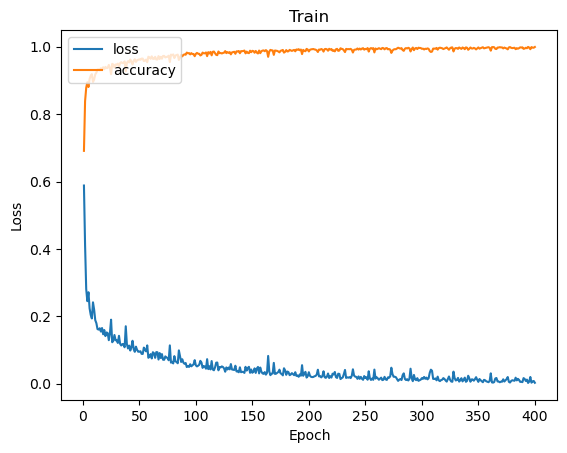

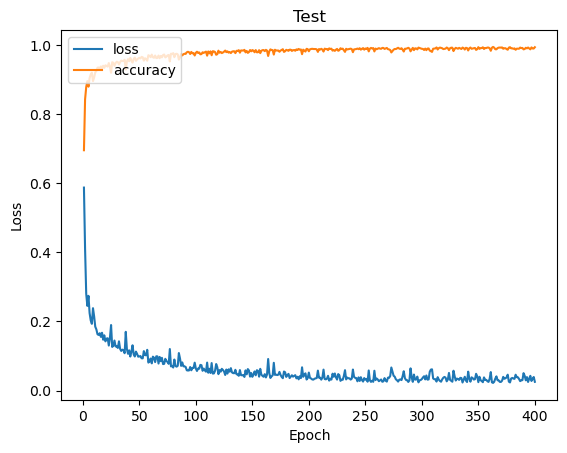

In [27]:
plot_graph(train_eva_df,'Train','Epoch','Loss',['loss','accuracy'])
plot_graph(test_eva_df,'Test','Epoch','Loss',['loss','accuracy'])